In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
cd ../src

/home/theo/mva/altegrad/challenge/src


In [35]:
from util import *
from params import *
from imports import *

from post_processing import *

In [36]:
seed_everything(SEED)

# Data

## Labels & nodes

In [37]:
sub = pd.read_csv(DATA_PATH + 'graph_baseline.csv')

In [38]:
df_train = pd.read_csv(DATA_PATH + 'train.csv', names=['node', 'class'])
df_test = pd.read_csv(DATA_PATH + 'test.csv', names=['node'])

In [39]:
df_train.head()

,node,class
0,9032,health/medical
1,5346,entertainment
2,18778,entertainment
3,11939,education/research
4,17502,tech/science


In [40]:
nodes_train = list(df_train['node'])
nodes_test = list(df_test['node'])

In [41]:
nodes = nodes_test + nodes_train

In [42]:
y_train = np.array([CLASSES.index(c) for c in df_train['class'].values])

## Graph

In [43]:
G = nx.read_weighted_edgelist(DATA_PATH + 'edgelist.txt', create_using=nx.DiGraph())
nodes_indexing = list(np.array(list(G.nodes)).astype(int))

In [44]:
full_graph = nx.adjacency_matrix(G).toarray()

## Texts

In [45]:
df_texts = pd.read_csv('../output/df_texts.csv')

In [46]:
df_texts.head()

,text,len,treated_text,error,language,ids
0,#alternate alternate * français * ...,1057,* français * english * deutsch * chinese reche...,0,fr,951 430 951 22 12470 4264 951 8 1248 6487 951 ...
1,#alternate alternate alternate alternate al...,5000,iframe: URL offline icon you're browsing offli...,0,fr,1723 24967 92 20689 5303 2141 21 13389 4835 11...
2,#alternate alternate alternate alternate al...,5000,iframe: URL dackleader.se * * * för proffs * *...,0,sv,1723 24967 92 20689 18 5926 185 55 1526 9 10 3...
3,#alternate alternate alternate alternate al...,3718,iframe: URL property logo green-acres .com * h...,0,en,1723 24967 92 20689 909 14229 105 4761 24524 2...
4,#alternate iframe: https://www.googletagm...,5000,iframe: URL nous utilisons des cookies pour ré...,0,fr,1723 24967 92 20689 63 12400 20 3929 24 975 20...


In [47]:
errors = ((df_texts['language'].values != 'fr') + df_texts['error'].values >= 1).astype(int)
errors = (df_texts['error'].values >= 1).astype(int)

In [48]:
Counter(errors)

Counter({0: 26248, 1: 1755})

# $k$-fold

In [49]:
def k_fold_lgb(graph, nodes_indexing, nodes, nodes_test, features, errors, y, 
               seed=2019, k=5, n_neigh=5, remove_error=False):  
    X = np.array([get_knns_features(node, graph, features, nodes_indexing, errors, 
                                    k=n_neigh, remove_error=remove_error) for node in nodes])
        
    X_test = np.array([get_knns_features(node, graph, features, nodes_indexing, errors, 
                                         k=n_neigh, remove_error=remove_error) for node in nodes_test])
    
    print("Training data shape :", X.shape)
    
    splits = list(StratifiedKFold(n_splits=k, random_state=seed).split(X=nodes, y=y))
    
    pred_oof = np.zeros((len(nodes), NUM_CLASSES))
    pred_test = np.zeros((len(nodes_test), NUM_CLASSES))
    
    for i, (train_idx, val_idx) in enumerate(splits):
        print('')
        clf = run_lgb(X[train_idx], X[val_idx], y[train_idx], y[val_idx])

        pred_val = clf.predict(X[val_idx])
        
        pred_oof[val_idx] = pred_val
        pred_test += clf.predict(X_test) / k

    val_loss = cross_entropy(pred_oof, y)
    print(f'\n CV = {val_loss :.3f}') 
    
    return pred_oof, pred_test

# Modeling

In [50]:
models = [
    'camembert-base_1.151_augment_notrad',
    'camembert-base_1.151_noaugment_notrad',
    'camembert-base_1.137_noaugment_trad',
    'camembert-base_1.144_augment_trad',
    'camembert-base_1.136_noaugment_trad_avg',
]

In [51]:
pred_fts = []
pred_oofs = []

In [52]:
for model in models:
    pred_fts.append(np.load(f'../output/pred_ft_{model}.npy'))
    pred_oofs.append(np.load(f'../output/pred_oof_{model}.npy'))

In [53]:
pred_oof = np.mean(pred_oofs, 0)
pred_ft = np.mean(pred_fts, 0)

In [54]:
features = np.zeros((len(df_texts), pred_oof.shape[-1]))
ft_nodes = np.array([i for i in range(len(df_texts)) if i not in nodes_train])

features[np.array(nodes_train)] = pred_oof
features[ft_nodes] = pred_ft

In [55]:
pred_oof, pred_test = k_fold_lgb(full_graph, nodes_indexing, nodes_train,
                                 nodes_test, features, errors, y_train,
                                 seed=SEED, k=5, n_neigh=2, remove_error=False)

Training data shape : (2125, 40)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 1.47778
[200]	valid_0's multi_logloss: 1.34983
[300]	valid_0's multi_logloss: 1.28211
[400]	valid_0's multi_logloss: 1.24186
[500]	valid_0's multi_logloss: 1.21798
[600]	valid_0's multi_logloss: 1.20442
[700]	valid_0's multi_logloss: 1.19645
[800]	valid_0's multi_logloss: 1.19077
[900]	valid_0's multi_logloss: 1.1868
[1000]	valid_0's multi_logloss: 1.18405
[1100]	valid_0's multi_logloss: 1.1827
[1200]	valid_0's multi_logloss: 1.18155
[1300]	valid_0's multi_logloss: 1.18063
[1400]	valid_0's multi_logloss: 1.18022
[1500]	valid_0's multi_logloss: 1.18033
Early stopping, best iteration is:
[1394]	valid_0's multi_logloss: 1.18016

Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 1.43222
[200]	valid_0's multi_logloss: 1.28056
[300]	valid_0's multi_logloss: 1.19327
[400]	valid_0's multi_logloss: 1.14222
[500]	valid_0's multi

In [56]:
score = cross_entropy(pred_oof, y_train)
print(f" -> Local CV score is {score:.3f}")

 -> Local CV score is 1.093


# Blending after modeling

In [57]:
pred_oofs = []
pred_tests = []

In [58]:
for model in models:
    
    print(f'\n Model : {model}')
    pred_ft = np.load(f'../output/pred_ft_{model}.npy')
    pred_oof = np.load(f'../output/pred_oof_{model}.npy')
    
    features = np.zeros((len(df_texts), pred_oof.shape[-1]))
    ft_nodes = np.array([i for i in range(len(df_texts)) if i not in nodes_train])

    features[np.array(nodes_train)] = pred_oof
    features[ft_nodes] = pred_ft

    pred_oof, pred_test = k_fold_lgb(full_graph, nodes_indexing, nodes_train,
                                 nodes_test, features, errors, y_train,
                                 seed=SEED, k=5, n_neigh=1, remove_error=True)
    pred_oofs.append(pred_oof)
    pred_tests.append(pred_test)


 Model : camembert-base_1.151_augment_notrad
Training data shape : (2125, 24)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 1.49349
[200]	valid_0's multi_logloss: 1.365
[300]	valid_0's multi_logloss: 1.29857
[400]	valid_0's multi_logloss: 1.26142
[500]	valid_0's multi_logloss: 1.23975
[600]	valid_0's multi_logloss: 1.22357
[700]	valid_0's multi_logloss: 1.21323
[800]	valid_0's multi_logloss: 1.20635
[900]	valid_0's multi_logloss: 1.20173
[1000]	valid_0's multi_logloss: 1.19834
[1100]	valid_0's multi_logloss: 1.19662
[1200]	valid_0's multi_logloss: 1.19542
[1300]	valid_0's multi_logloss: 1.19467
[1400]	valid_0's multi_logloss: 1.19387
[1500]	valid_0's multi_logloss: 1.19336
[1600]	valid_0's multi_logloss: 1.19272
[1700]	valid_0's multi_logloss: 1.19255
[1800]	valid_0's multi_logloss: 1.1925
[1900]	valid_0's multi_logloss: 1.19286
Early stopping, best iteration is:
[1737]	valid_0's multi_logloss: 1.19236

Training until validation scores d

Early stopping, best iteration is:
[1386]	valid_0's multi_logloss: 1.18313

Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 1.4348
[200]	valid_0's multi_logloss: 1.28443
[300]	valid_0's multi_logloss: 1.19988
[400]	valid_0's multi_logloss: 1.14889
[500]	valid_0's multi_logloss: 1.11902
[600]	valid_0's multi_logloss: 1.10064
[700]	valid_0's multi_logloss: 1.08869
[800]	valid_0's multi_logloss: 1.08136
[900]	valid_0's multi_logloss: 1.07615
[1000]	valid_0's multi_logloss: 1.07246
[1100]	valid_0's multi_logloss: 1.07062
[1200]	valid_0's multi_logloss: 1.06979
[1300]	valid_0's multi_logloss: 1.06902
[1400]	valid_0's multi_logloss: 1.06838
[1500]	valid_0's multi_logloss: 1.06773
[1600]	valid_0's multi_logloss: 1.06735
[1700]	valid_0's multi_logloss: 1.06721
[1800]	valid_0's multi_logloss: 1.06692
[1900]	valid_0's multi_logloss: 1.06677
[2000]	valid_0's multi_logloss: 1.0664
[2100]	valid_0's multi_logloss: 1.06589
[2200]	valid_0's multi_logloss: 1

[1600]	valid_0's multi_logloss: 1.18016
Early stopping, best iteration is:
[1444]	valid_0's multi_logloss: 1.17847

Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 1.44605
[200]	valid_0's multi_logloss: 1.29503
[300]	valid_0's multi_logloss: 1.21034
[400]	valid_0's multi_logloss: 1.15826
[500]	valid_0's multi_logloss: 1.12496
[600]	valid_0's multi_logloss: 1.10582
[700]	valid_0's multi_logloss: 1.09313
[800]	valid_0's multi_logloss: 1.08499
[900]	valid_0's multi_logloss: 1.07964
[1000]	valid_0's multi_logloss: 1.07633
[1100]	valid_0's multi_logloss: 1.07472
[1200]	valid_0's multi_logloss: 1.07404
[1300]	valid_0's multi_logloss: 1.0737
[1400]	valid_0's multi_logloss: 1.07353
[1500]	valid_0's multi_logloss: 1.07362
[1600]	valid_0's multi_logloss: 1.07341
[1700]	valid_0's multi_logloss: 1.07371
Early stopping, best iteration is:
[1596]	valid_0's multi_logloss: 1.07335

Training until validation scores don't improve for 200 rounds
[100]	valid_0'

In [59]:
pred_oof = np.mean(pred_oofs, 0)
pred_test = np.mean(pred_tests, 0)

In [60]:
score = cross_entropy(pred_oof, y_train)
print(f" -> Local CV score is {score:.3f}")

 -> Local CV score is 1.081


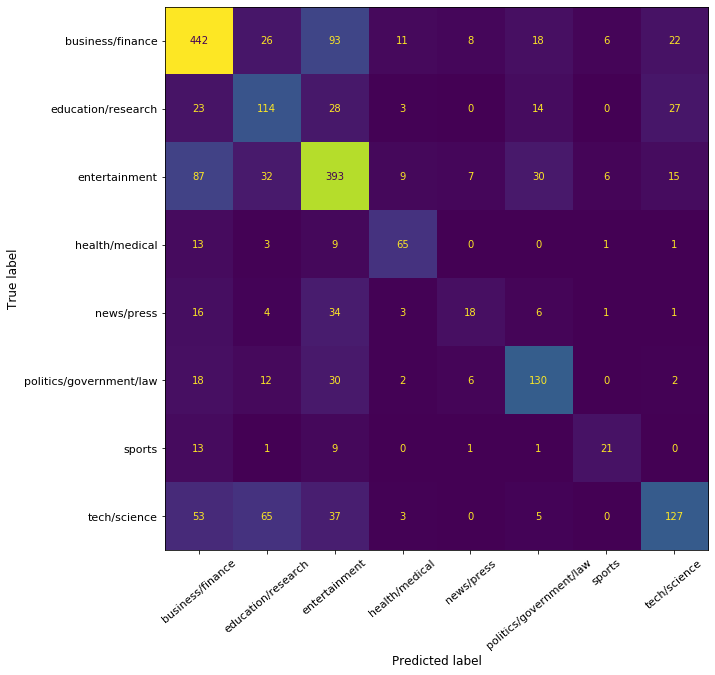

In [61]:
from util import plot_confusion_matrix
plot_confusion_matrix(np.argmax(pred_oof, -1), y_train)
plt.show()

In [62]:
sub[CLASSES] = pred_test
sub.to_csv(f'../output/sub_{score:.3f}_graph.csv', index=False)